In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### OpenAI Gym: A python library that wraps many classical decision problems including robot control,videogames, and board games 

In [62]:
import gym
env = gym.make("Taxi-v2")
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [63]:
n_states = env.observation_space.n
n_actions = env.action_space.n
print("n_states=%i, n_actions=%i" % (n_states,n_actions))

n_states=500, n_actions=6


# Create Stochastic Policy 

In [64]:
policy = np.full((n_states,n_actions),1./n_actions) # stochastic policy: at each state, equal chance to take any of the six actions

In [65]:
policy

array([[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       ...,
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667]])

In [68]:
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1),1)

In [69]:
s = env.reset()

In [70]:
policy[s,:]

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

# Play the Game 

In [71]:
def generate_session(policy,t_max=10**4):
    states,actions=[],[]
    total_reward=0.
    s = env.reset()
    for t in range(t_max):
        a = np.random.choice(np.arange(n_actions), p =policy[s])
        new_s,r,done,info = env.step(a)
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        if done:
            break
    return states,actions,total_reward

In [72]:
s,a,r = generate_session(policy)

In [73]:
assert type(s)==type(a)==list
assert len(s)==len(a)
assert type(r) in [float,np.float]

In [74]:
sample_rewards = [generate_session(policy,t_max=1000)[-1] for _ in range(200)] # run 200 such sessions, each for maxium 1000 timesteps

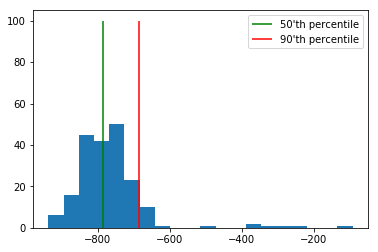

In [75]:
plt.hist(sample_rewards,bins=20)
plt.vlines([np.percentile(sample_rewards,50)],[0],[100],label="50'th percentile",color='green')
plt.vlines([np.percentile(sample_rewards,90)],[0],[100],label="90'th percentile",color="red")
plt.legend()

# Cross-Entropy Method 

In [76]:
def select_elites(states_batch, actions_batch, rewards_batch,percentile=50):
    reward_threshold = np.percentile(rewards_batch,percentile)
    
    elite_states  = np.array(states_batch)[rewards_batch >= reward_threshold]
    elite_states = [y for x in elite_states for y in x]
    elite_actions = np.array(actions_batch)[rewards_batch >= reward_threshold]
    elite_actions = [y for x in elite_actions for y in x]
    
    return elite_states,elite_actions

In [77]:
states_batch = [
    [1,2,3],   #game1
    [4,2,0,2], #game2
    [3,1]      #game3
]

actions_batch = [
    [0,2,4],   #game1
    [3,2,0,1], #game2
    [3,3]      #game3
]
rewards_batch = [
    3,         #game1
    4,         #game2
    5,         #game3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_40 = select_elites(states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [78]:
def update_policy(elite_states,elite_actions):
    
    new_policy = np.zeros([n_states,n_actions])
    occurences = {}
    
    for idx in range(n_states):
        occurences[idx] = 0
      
    for index,state in enumerate(elite_states):
        new_policy[state,elite_actions[index]] += 1 
        occurences[state] += 1
        
    for idx in range(n_states):
        if occurences[idx] == 0:
            new_policy[idx,:] = 1./n_actions
        else:
            new_policy[idx,:] /= occurences[idx]
    
    return new_policy    

In [79]:
elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

Ok!


In [80]:
from IPython.display import clear_output

def show_progress(batch_rewards, log, percentile, reward_range=[-990,+10]):
    
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward, threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards,range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [81]:
#reset policy just in case
policy = np.ones([n_states, n_actions]) / n_actions 

mean reward = -20.924, threshold=6.000


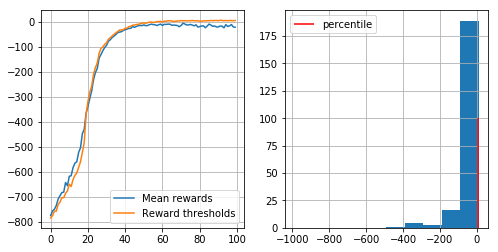

In [82]:
n_sessions = 250  #sample this many sessions
percentile = 50  #take this percent of session with highest rewards
learning_rate = 0.2  #add this thing to all counts for stability

log = []

for i in range(100):
    
    sessions =  [generate_session(policy) for _ in range(n_sessions)]#[<generate a list of n_sessions new sessions>]
    
    batch_states,batch_actions,batch_rewards = zip(*sessions)

    elite_states, elite_actions = select_elites(batch_states,batch_actions,batch_rewards,percentile)
    
    new_policy = update_policy(elite_states,elite_actions)
    
    policy = learning_rate * new_policy + (1-learning_rate) * policy
    
    #display results on chart
    show_progress(batch_rewards, log, percentile)